# Geometría y Cinemática de las Patas de un Robot

## Geometría de las Patas del Robot

Consideremos un robot con una pata que tiene dos articulaciones:
1. **Cadera** (`theta1`): Une el torso del robot a la parte superior de la pierna.
2. **Rodilla** (`theta2`): Une la parte superior de la pierna a la parte inferior.

Las longitudes de los eslabones son:
- \( l1 \): Longitud desde la cadera hasta la rodilla.
- \( l2 \): Longitud desde la rodilla hasta el pie.

## Cinemática Directa

La matriz de transformación homogénea para una rotación y una traslación en 2D se puede representar como:



\begin{equation}
\left[
\begin{matrix}
cos(\theta) & -\sin(\theta) & d_x \\
sin(\theta) & \cos(\theta) & d_y \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}

Para nuestro robot, necesitamos dos matrices de transformación:
1. Desde la cadera hasta la rodilla.
2. Desde la rodilla hasta el pie.

## Matrices de Transformación

Para la cadera a la rodilla:

\begin{equation}
\left[
\begin{matrix}
cos(\theta_1) & -\sin(\theta_1) & l1 \cos(\theta_1) \\
sin(\theta_1) & \cos(\theta_1) & l1 \sin(\theta_1) \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}

Para la rodilla al pie:

\begin{equation}
\left[
\begin{matrix}
cos(\theta_2) & -\sin(\theta_2) & l2 \cos(\theta_2) \\
sin(\theta_2) & \cos(\theta_2) & l2 \sin(\theta_2) \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}


La posición final del pie se obtiene multiplicando estas matrices.

\begin{equation}
\left[
\begin{matrix}
\cos{\left(\theta_{1} + \theta_{2} \right)} & - \sin{\left(\theta_{1} + \theta_{2} \right)} & l_{1} \cos{\left(\theta_{1} \right)} + l_{2} \cos{\left(\theta_{1} + \theta_{2} \right)} \\
\sin{\left(\theta_{1} + \theta_{2} \right)} & \cos{\left(\theta_{1} + \theta_{2} \right)} & l_{1} \sin{\left(\theta_{1} \right)} + l_{2} \sin{\left(\theta_{1} + \theta_{2} \right)} \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}



### IMPORTS

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle


calibrations = {}

DERECHA_SUPERIOR = 0
DERECHA_INFERIOR = 1
IZQUIERDA_SUPERIOR = 2
IZQUIERDA_INFERIOR = 3

### PASOS DEL ROBOT PARA MOVER UNA PIERNA

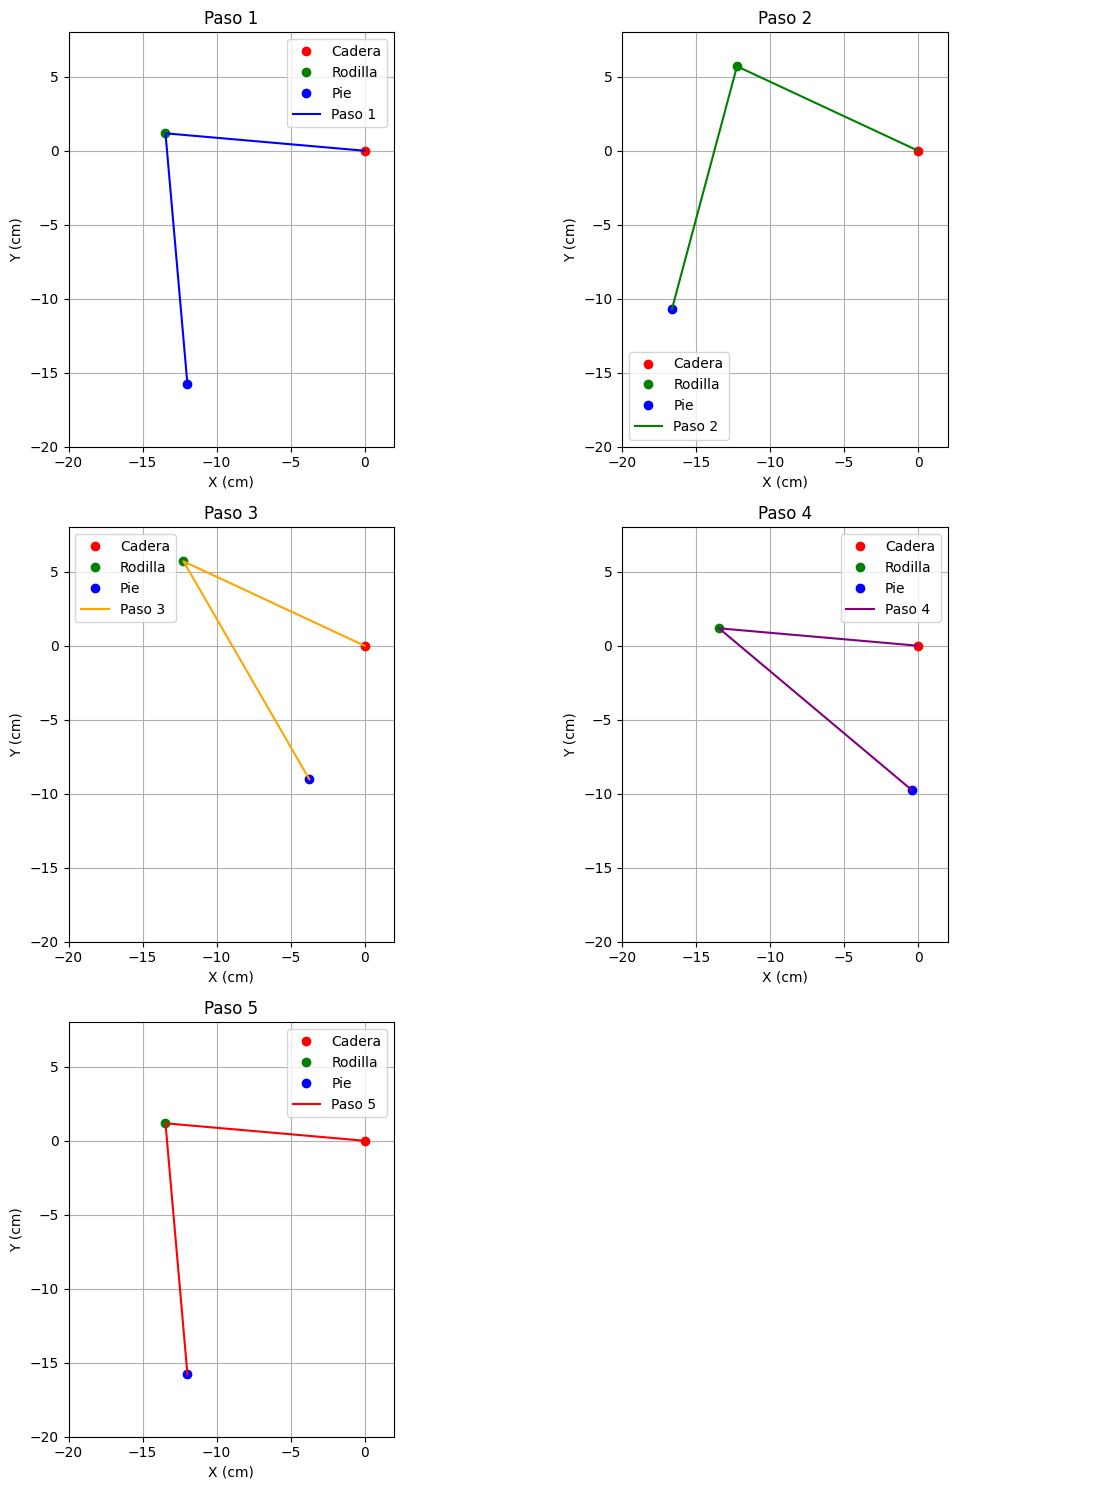

In [32]:

# Longitudes de los eslabones
l1 = 13.5  # longitud de la cadera a la rodilla (cm)
l2 = 17  # longitud de la rodilla al pie (cm)

# Ángulos de las articulaciones (en grados) para los cinco pasos
thetas = [
    (175, 100),  # Paso 1
    (155, 100),   # Paso 2
    (155, 145),   # Paso 3
    (175, 145),  # Paso 4
    (175, 100)   # Paso 5 (volver al paso inicial)
]

# Colores para los diferentes pasos
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Crear la figura y los ejes para los cinco subgráficos
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
axs = axs.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre cada paso y visualizar la posición del pie en cada paso
for i, (theta1, theta2) in enumerate(thetas, start=1):
    # Calcular las coordenadas del pie (posición final)
    x_foot = l1 * np.cos(np.radians(theta1)) + l2 * np.cos(np.radians(theta1 + theta2))
    y_foot = l1 * np.sin(np.radians(theta1)) + l2 * np.sin(np.radians(theta1 + theta2))
    
    # Visualizar la posición del pie en el subgráfico correspondiente
    ax = axs[i-1]
    ax.plot(0, 0, 'ro', label='Cadera')
    ax.plot(l1 * np.cos(np.radians(theta1)), l1 * np.sin(np.radians(theta1)), 'go', label='Rodilla')
    ax.plot(x_foot, y_foot, 'bo', label='Pie')
    ax.plot([0, l1 * np.cos(np.radians(theta1)), x_foot], [0, l1 * np.sin(np.radians(theta1)), y_foot], 
            color=colors[i-1], label=f'Paso {i}')

    # Configurar el subgráfico
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f'Paso {i}')
    ax.grid(True)
    ax.set_xlim(-20, 2)
    ax.set_ylim(-20, 8)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()

# Añadir un espacio vacío para el último subgráfico que no se usa
axs[5].axis('off')

plt.tight_layout()
plt.show()


### FUNCIONES DE CALIBRACIÓN, MAPEADO DE ANGULOS 

In [33]:
# Función de calibración
def calibrate_servo(servo_name, joint_angle_ref, servo_angle_ref, calibrations):
    calibrations[servo_name] = {
        'joint_angle_ref': joint_angle_ref,
        'servo_angle_ref': servo_angle_ref,
    }
    return calibrations

# Función de mapeo de ángulos
def map_angle_to_servo(servo_name, joint_angle, calibrations):
    calib = calibrations[servo_name]
    
    if DERECHA_SUPERIOR == servo_name:
        servo_angle = (calib['joint_angle_ref'] - joint_angle) + calib['servo_angle_ref']
    elif DERECHA_INFERIOR == servo_name:
        servo_angle = (calib['joint_angle_ref'] - joint_angle) + calib['servo_angle_ref']
    elif IZQUIERDA_SUPERIOR == servo_name:
        servo_angle = (joint_angle - calib['joint_angle_ref']) + calib['servo_angle_ref']
    elif IZQUIERDA_INFERIOR == servo_name:
        servo_angle = (joint_angle - calib['joint_angle_ref']) + calib['servo_angle_ref']
    else:
        return None
    
    if servo_angle < 0 or servo_angle > 180:
        return None
    return servo_angle

# Función de mapeo de servo a ángulo
def map_servo_to_angle(servo_name, servo_angle, calibrations):
    if servo_angle < 0 or servo_angle > 180:
        return None
    
    calib = calibrations[servo_name]
    
    if DERECHA_SUPERIOR == servo_name:
        joint_angle = calib['joint_angle_ref'] + (calib['servo_angle_ref'] - servo_angle)
    elif DERECHA_INFERIOR == servo_name:
        joint_angle = calib['joint_angle_ref'] + (calib['servo_angle_ref'] - servo_angle)
    elif IZQUIERDA_SUPERIOR == servo_name:
        joint_angle = (servo_angle - calib['servo_angle_ref']) + calib['joint_angle_ref']
    elif IZQUIERDA_INFERIOR == servo_name:
        joint_angle = (servo_angle - calib['servo_angle_ref']) + calib['joint_angle_ref']
    else:
        return None

    return joint_angle

# Función de prueba para calibrate_servo
def test_calibrate_servo():
    calibrations = {}
    calibrate_servo(IZQUIERDA_SUPERIOR, 185, 30, calibrations)
    calibrate_servo(IZQUIERDA_INFERIOR, 100, 135, calibrations)
    calibrate_servo(DERECHA_SUPERIOR, 185, 150, calibrations)
    calibrate_servo(DERECHA_INFERIOR, 100, 45, calibrations)

    assert calibrations[IZQUIERDA_SUPERIOR] == {'joint_angle_ref': 185, 'servo_angle_ref': 30}
    assert calibrations[IZQUIERDA_INFERIOR] == {'joint_angle_ref': 100, 'servo_angle_ref': 135}
    assert calibrations[DERECHA_SUPERIOR] == {'joint_angle_ref': 185, 'servo_angle_ref': 150}
    assert calibrations[DERECHA_INFERIOR] == {'joint_angle_ref': 100, 'servo_angle_ref': 45}
    print("test_calibrate_servo passed")

# Función de prueba para map_angle_to_servo
def test_map_angle_to_servo():
    calibrations = {}
    calibrate_servo(IZQUIERDA_SUPERIOR, 185, 30, calibrations)
    calibrate_servo(IZQUIERDA_INFERIOR, 100, 135, calibrations)
    calibrate_servo(DERECHA_SUPERIOR, 185, 150, calibrations)
    calibrate_servo(DERECHA_INFERIOR, 100, 45, calibrations)

    # Testing map_angle_to_servo
    assert map_angle_to_servo(IZQUIERDA_SUPERIOR, 175, calibrations) == 20
    assert map_angle_to_servo(IZQUIERDA_INFERIOR, 100, calibrations) == 135
    assert map_angle_to_servo(DERECHA_SUPERIOR, 175, calibrations) == 160
    assert map_angle_to_servo(DERECHA_INFERIOR, 100, calibrations) == 45
    assert map_angle_to_servo(DERECHA_SUPERIOR, 120, calibrations) == None

    print("test_map_angle_to_servo passed")

# Función de prueba para map_servo_to_angle
def test_map_servo_to_angle():
    calibrations = {}
    calibrate_servo(IZQUIERDA_SUPERIOR, 185, 30, calibrations)
    calibrate_servo(IZQUIERDA_INFERIOR, 100, 135, calibrations)
    calibrate_servo(DERECHA_SUPERIOR, 185, 150, calibrations)
    calibrate_servo(DERECHA_INFERIOR, 100, 45, calibrations)


    # Testing map_servo_to_angle
    
    assert map_servo_to_angle(IZQUIERDA_SUPERIOR, 20, calibrations) == 175
    assert map_servo_to_angle(IZQUIERDA_INFERIOR, 135, calibrations) == 100
    assert map_servo_to_angle(DERECHA_SUPERIOR, 160, calibrations) == 175
    assert map_servo_to_angle(DERECHA_INFERIOR, 45, calibrations) == 100
    assert map_servo_to_angle(DERECHA_INFERIOR, 200, calibrations) == None

    print("test_map_servo_to_angle passed")


In [34]:

# Ejecución de las pruebas
test_calibrate_servo()
test_map_angle_to_servo()
test_map_servo_to_angle()


test_calibrate_servo passed
test_map_angle_to_servo passed
test_map_servo_to_angle passed


### CONVERSIÓN DE ANGULOS EN REPRESENTACIÓN GEOMÉTRICA A ANGULOS EN SERVOS

In [35]:

# Calibración proporcionada por el usuario
calibrations = calibrate_servo(IZQUIERDA_SUPERIOR, 185, 30, calibrations)  # Calibración del servo 1: (185 en esquema) => 150 grados en el servo
calibrations = calibrate_servo(IZQUIERDA_INFERIOR, 100, 135, calibrations)   # Calibración del servo 2: (100 en esquema) => 130 grados en el servo
calibrations = calibrate_servo(DERECHA_SUPERIOR, 185, 150, calibrations)  # Calibración del servo 1: (185 en esquema) => 150 grados en el servo
calibrations = calibrate_servo(DERECHA_INFERIOR, 100, 45, calibrations)   # Calibración del servo 2: (100 en esquema) => 45 grados en el servo


# Los ángulos de las articulaciones para los cinco pasos
joint_angles = [
    (175, 100),  # Paso 1
    (155, 100),   # Paso 2
    (155, 145),   # Paso 3
    (175, 145),  # Paso 4
    (175, 100),   # Paso 5 (volver al paso inicial)
]

servo_angles_izquierda = []
for joint1, joint2 in joint_angles:
    servo1 = map_angle_to_servo(IZQUIERDA_SUPERIOR, joint1, calibrations)
    servo2 = map_angle_to_servo(IZQUIERDA_INFERIOR, joint2, calibrations)
    
    if (servo1 == None or servo2 == None):
        continue
    servo_angles_izquierda.append((servo1, servo2))


servo_angles_derecha =[]
for joint1, joint2 in joint_angles:
    servo1 = map_angle_to_servo(DERECHA_SUPERIOR, joint1, calibrations)
    servo2 = map_angle_to_servo(DERECHA_INFERIOR, joint2, calibrations)
    if (servo1 == None or servo2 == None):
        continue
    servo_angles_derecha.append((servo1, servo2))

for i, (servo1, servo2) in enumerate(servo_angles_derecha, start=1):
    print(f'Paso {i}: Servo 1: {servo1:.2f} grados, Servo 2: {servo2:.2f} grados')

print("------------------------------------------------------------------")

for i, (servo1, servo2) in enumerate(servo_angles_izquierda, start=1):
    print(f'Paso {i}: Servo 1: {servo1:.2f} grados, Servo 2: {servo2:.2f} grados')

Paso 1: Servo 1: 160.00 grados, Servo 2: 45.00 grados
Paso 2: Servo 1: 180.00 grados, Servo 2: 45.00 grados
Paso 3: Servo 1: 180.00 grados, Servo 2: 0.00 grados
Paso 4: Servo 1: 160.00 grados, Servo 2: 0.00 grados
Paso 5: Servo 1: 160.00 grados, Servo 2: 45.00 grados
------------------------------------------------------------------
Paso 1: Servo 1: 20.00 grados, Servo 2: 135.00 grados
Paso 2: Servo 1: 0.00 grados, Servo 2: 135.00 grados
Paso 3: Servo 1: 0.00 grados, Servo 2: 180.00 grados
Paso 4: Servo 1: 20.00 grados, Servo 2: 180.00 grados
Paso 5: Servo 1: 20.00 grados, Servo 2: 135.00 grados


### CINEMÁTICA INVERSA Y DIRECTA PARA FUNCIÓN DE BAJAR CENTRO DE GRAVEDAD

In [36]:
def cinemática_directa(theta1, theta2):
    """
    Calcula las coordenadas de la rodilla y del pie dados los ángulos de las articulaciones.
    """
    x_rodilla = l1 * np.cos(np.radians(theta1))
    y_rodilla = l1 * np.sin(np.radians(theta1))
    
    x_pie = x_rodilla + l2 * np.cos(np.radians(theta1 + theta2))
    y_pie = y_rodilla + l2 * np.sin(np.radians(theta1 + theta2))
    
    return (x_rodilla, y_rodilla), (x_pie, y_pie)

def cinemática_inversa(x_pie, y_pie, y_hip_new):
    """
    Calcula los ángulos de la cadera y la rodilla para una posición dada del pie y una nueva altura de la cadera.
    """
    d = np.sqrt(x_pie**2 + (y_pie - y_hip_new)**2)
    alpha = np.arctan2(y_pie - y_hip_new, x_pie)
    beta = np.arccos((l1**2 + d**2 - l2**2) / (2 * l1 * d))
    
    theta1 = np.degrees(alpha - beta)
    theta2 = np.degrees(np.arccos((l1**2 + l2**2 - d**2) / (2 * l1 * l2))) - 180
    
    
    return theta1, theta2


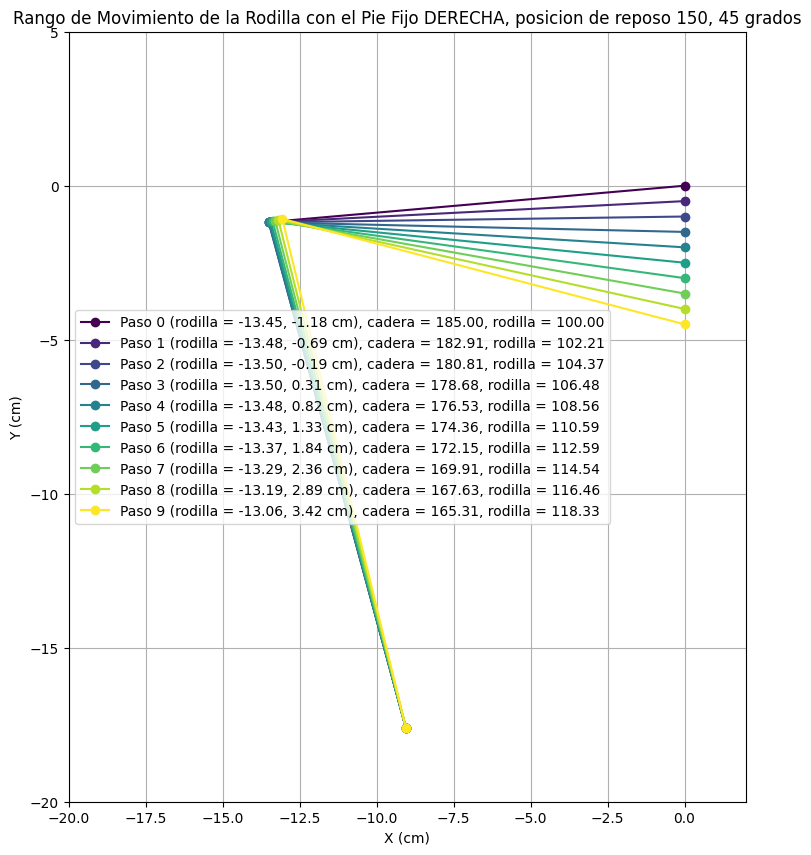

In [37]:
theta1_inicial = map_servo_to_angle(DERECHA_SUPERIOR, 150, calibrations)
theta2_inicial = map_servo_to_angle(DERECHA_INFERIOR, 45, calibrations)

desplazamiento_vertical = -0.5  # bajar 1 cm
pasos = 9

_, (x_pie, y_pie) = cinemática_directa(theta1_inicial, theta2_inicial)

fig, ax = plt.subplots(figsize=(10, 10))

# Colores para los diferentes pasos
colors = plt.cm.viridis(np.linspace(0, 1, pasos+1))

# Lista para almacenar la posición de la rodilla en cada paso
posiciones_rodilla = []

# Visualizar el rango de movimiento de la rodilla para cada posición de la cadera
for i in range(pasos + 1):
    y_hip_new = i * desplazamiento_vertical

    # Calcular los nuevos ángulos para mantener la posición del pie constante
    theta1_new, theta2_new = cinemática_inversa(x_pie, y_pie, y_hip_new)
    theta2_new = np.abs(theta2_new)

    if theta1_new < 0:
        theta1_new += 360

    (rodilla_x, rodilla_y), _ = cinemática_directa(theta1_new, theta2_new)

    # Visualizar la posición ajustada
    ax.plot([0, rodilla_x, x_pie], [y_hip_new, rodilla_y + y_hip_new, y_pie], 'o-', color=colors[i], label=f'Paso {i} (rodilla = {rodilla_x:.2f}, {rodilla_y:.2f} cm), cadera = {theta1_new:.2f}, rodilla = {theta2_new:.2f}')
    posiciones_rodilla.append((rodilla_x, rodilla_y))

# Configurar el gráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title(f'Rango de Movimiento de la Rodilla con el Pie Fijo DERECHA, posicion de reposo 150, 45 grados')
ax.grid(True)
ax.set_xlim(-20, 2)
ax.set_ylim(-20, 5)
ax.set_aspect('equal', adjustable='box')


ax.legend()
plt.show()


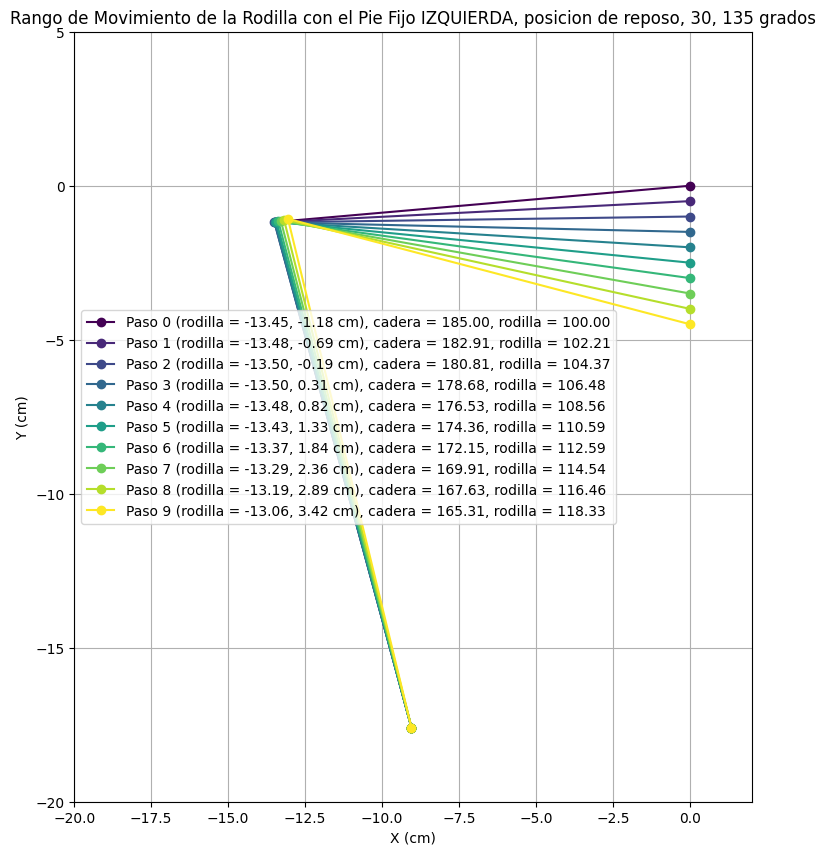

In [38]:
theta1_inicial = map_servo_to_angle(IZQUIERDA_SUPERIOR, 30, calibrations)
theta2_inicial = map_servo_to_angle(IZQUIERDA_INFERIOR, 135, calibrations)

desplazamiento_vertical = -0.5  # bajar 1 cm
pasos = 9

_, (x_pie, y_pie) = cinemática_directa(theta1_inicial, theta2_inicial)

fig, ax = plt.subplots(figsize=(10, 10))

# Colores para los diferentes pasos
colors = plt.cm.viridis(np.linspace(0, 1, pasos+1))

# Lista para almacenar la posición de la rodilla en cada paso
posiciones_rodilla = []

# Visualizar el rango de movimiento de la rodilla para cada posición de la cadera
for i in range(pasos + 1):
    y_hip_new = i * desplazamiento_vertical

    # Calcular los nuevos ángulos para mantener la posición del pie constante
    theta1_new, theta2_new = cinemática_inversa(x_pie, y_pie, y_hip_new)
    theta2_new = np.abs(theta2_new)

    if theta1_new < 0:
        theta1_new += 360

    (rodilla_x, rodilla_y), _ = cinemática_directa(theta1_new, theta2_new)

    # Visualizar la posición ajustada
    ax.plot([0, rodilla_x, x_pie], [y_hip_new, rodilla_y + y_hip_new, y_pie], 'o-', color=colors[i], label=f'Paso {i} (rodilla = {rodilla_x:.2f}, {rodilla_y:.2f} cm), cadera = {theta1_new:.2f}, rodilla = {theta2_new:.2f}')
    posiciones_rodilla.append((rodilla_x, rodilla_y))

# Configurar el gráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title('Rango de Movimiento de la Rodilla con el Pie Fijo IZQUIERDA, posicion de reposo, 30, 135 grados')
ax.grid(True)
ax.set_xlim(-20, 2)
ax.set_ylim(-20, 5)
ax.set_aspect('equal', adjustable='box')


ax.legend()
plt.show()


### FUNCIÓN QUE BAJA EL CENTRO DE GRAVEDAD EN FUNCIÓN DE UN DESPLAZAMIENTO

In [39]:
def bajar_cadera(type, servo1, servo2, desplazamiento_vertical):
    """
    Baja la cadera a una nueva altura sin cambiar la posición del pie.
    """
    # Calcular los nuevos ángulos para mantener la posición del pie constante
    
    if type == "DERECHA": 
        theta1_inicial = map_servo_to_angle(DERECHA_SUPERIOR, servo1, calibrations)
        theta2_inicial = map_servo_to_angle(DERECHA_INFERIOR, servo2, calibrations)
    elif type == "IZQUIERDA":
        theta1_inicial = map_servo_to_angle(IZQUIERDA_SUPERIOR, servo1, calibrations)
        theta2_inicial = map_servo_to_angle(IZQUIERDA_INFERIOR, servo2, calibrations)
    else:
        return None
    
    _, (x_pie, y_pie) = cinemática_directa(theta1_inicial, theta2_inicial)
    
    theta1_new, theta2_new = cinemática_inversa(x_pie, y_pie, desplazamiento_vertical)
    theta2_new = np.abs(theta2_new)
    
    if (theta1_new < 0):
        theta1_new = theta1_new + 360
    
        (rodilla_x, rodilla_y), _ = cinemática_directa(theta1_new, theta2_new)
    return (rodilla_x, rodilla_y), (theta1_new, theta2_new)

In [40]:
def test_bajar_cadera():
    # Caso de prueba 1: Tipo DERECHA
    type = "DERECHA"
    servo1 = 150
    servo2 = 45
    desplazamiento_vertical = -1.0
    (rodilla_pos, (theta1_new, theta2_new)) = bajar_cadera(type, servo1, servo2, desplazamiento_vertical)
    assert np.isclose(rodilla_pos[1], -0.19, atol=0.01)
    assert np.isclose(rodilla_pos[0], -13.5, atol=0.01)
    assert np.isclose(theta1_new, 180.81, atol=0.01)
    assert np.isclose(theta2_new, 104.37, atol=0.01)
    
    # Caso de prueba 2: Tipo IZQUIERDA
    type = "IZQUIERDA"
    servo1 = 30
    servo2 = 135
    desplazamiento_vertical = -0.5
    (rodilla_pos, (theta1_new, theta2_new)) = bajar_cadera(type, servo1, servo2, desplazamiento_vertical)
    assert np.isclose(rodilla_pos[0],-13.48, atol=0.01)
    assert np.isclose(rodilla_pos[1],-0.69, atol=0.01)
    assert np.isclose(theta1_new, 182.91, atol=0.01)    
    assert np.isclose(theta2_new, 102.21, atol=0.01)
    
    print("Pruebas de bajar_cadera completadas")

test_bajar_cadera()

Pruebas de bajar_cadera completadas


### VISUALIZACIÓN DE TODO EL ROBOT Y EL RANGO DE MOVIMIENTO DE CADA EJE

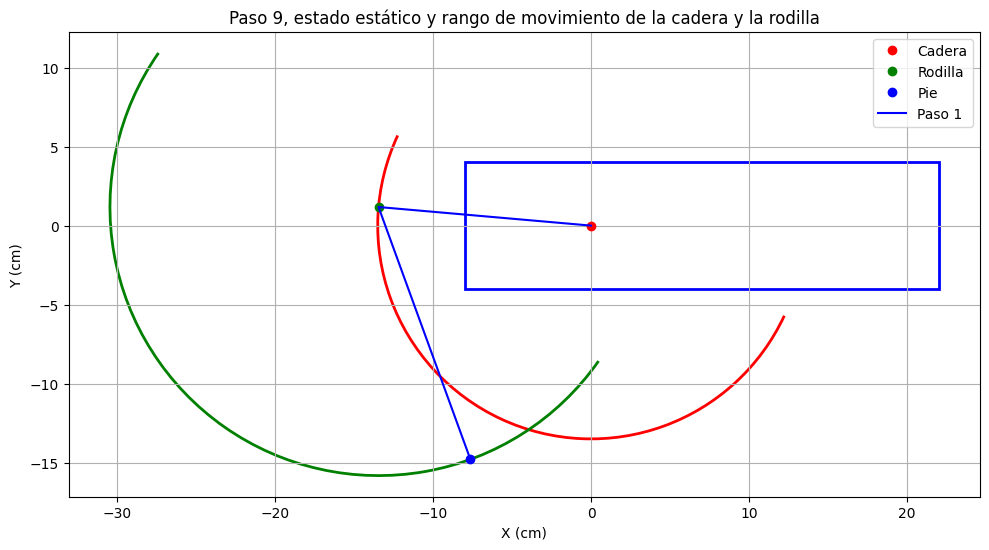

In [46]:
# Colores para los diferentes pasos
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Crear la figura y los ejes para los cinco subgráficos
fig, ax = plt.subplots(figsize=(10, 10))

servo1 = 160
servo2 = 30


angle_min_sup = map_servo_to_angle(DERECHA_SUPERIOR, 0, calibrations)
angle_max_sup = map_servo_to_angle(DERECHA_SUPERIOR, 180, calibrations)

angle_min_inf = map_servo_to_angle(DERECHA_INFERIOR, 0, calibrations)
angle_max_inf = map_servo_to_angle(DERECHA_INFERIOR, 180, calibrations)


theta1 = map_servo_to_angle(DERECHA_SUPERIOR, servo1, calibrations)
theta2 = map_servo_to_angle(DERECHA_INFERIOR, servo2, calibrations)

(rodilla_x, rodilla_y) , (x_foot, y_foot) = cinemática_directa(theta1, theta2)
    # Visualizar la posición del pie en el subgráfico correspondiente

ax.plot(0, 0, 'ro', label='Cadera')
ax.plot(l1 * np.cos(np.radians(theta1)), l1 * np.sin(np.radians(theta1)), 'go', label='Rodilla')
ax.plot(x_foot, y_foot, 'bo', label='Pie')
ax.plot([0, l1 * np.cos(np.radians(theta1)), x_foot], [0, l1 * np.sin(np.radians(theta1)), y_foot], 
            color='blue', label=f'Paso 1')

arc = Arc((0, 0),l1 * 2, l1 * 2, angle=0, theta1=angle_max_sup, theta2=angle_min_sup, linewidth=2, color='red')
ax.add_patch(arc)

arc = Arc((rodilla_x, rodilla_y),l2 * 2, l2 * 2, angle=0, theta1=angle_min_inf, theta2=angle_max_inf, linewidth=2, color='green')
ax.add_patch(arc)

# Crear la caja
caja = Rectangle((-8, -4), 30, 8, edgecolor='blue', facecolor='none', linewidth=2)

# Añadir la caja a los ejes
ax.add_patch(caja)

    # Configurar el subgráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title(f'Paso {i}, estado estático y rango de movimiento de la cadera y la rodilla')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
ax.legend()

plt.tight_layout()
plt.show()
